In [29]:
import re
import os
import sys
sys.path.insert(0, '../')
import time

import numpy as np
rng = np.random.RandomState(0)

import matplotlib.pyplot as plt
import scipy.stats as stats
import astropy.constants as constants
import astropy.units as u
import pandas as pd

import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

from src import GlobularCluster
from src.plot import LogNorm, AsinhNorm
from src.utils import profile_binning, clip_quantile_nd
from src.cluster import DBSCAN_Clustering

from src.plot import colobar_non_mappable

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
def sigmar_2(x, M_gc, r_scale, beta):
    sig2 = -(M_gc
            * (
                - 6 * beta
                - 36 * x ** 2 * beta
                - 70 * x ** 4 * beta
                - 56 * x ** 6 * beta
                - 16 * x ** 8 * beta
                + 48 * x ** 3 * np.sqrt(1 + x ** 2) * beta
                + 48 * x ** 5 * np.sqrt(1 + x ** 2) * beta
                + 16 * x ** 7 * np.sqrt(1 + x ** 2) * beta
                + x * np.sqrt(1 + x ** 2) * (-1 + 16 * beta)
            )
        ) / (6.0 * r_scale * x * (1 + x ** 2))

    return constants.G * u.solMass * sig2 / u.pc

In [49]:
sig = np.sqrt(sigmar_2(x, 1e6, 24, 0.001)).to_value(u.km/u.s)

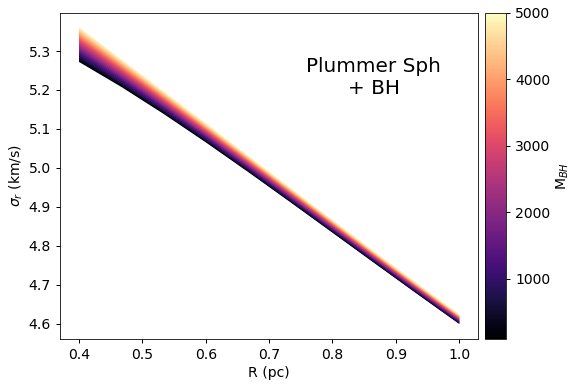

In [273]:
dist = 4.5e3 * u.pc
r_scale = 18.3 * u.arcmin.to(u.rad) * dist

R = np.linspace(0.4, 1, 10)

N_mod = 25
models = np.zeros((N_mod, len(R)))
f_BH_amp = np.linspace(1e-4,5e-3,N_mod)

fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.set_prop_cycle('color', plt.cm.magma(np.linspace(0,1,N_mod-1)))
for i, f_bh in enumerate(f_BH_amp[:-1]):
    mod = np.sqrt(sigmar_2(R, M_gc, r_scale.value, f_bh)).to_value(u.km/u.s)
    models[i] = mod
    if i>0:
        plt.fill_between(R, models[i-1]-0.001, mod+0.001, edgecolor="None")
        
plt.xlabel("R (pc)")
plt.ylabel("$\sigma_r$ (km/s)")
plt.text(0.75,0.8,"Plummer Sph\n+ BH", fontsize=20,
         ha="center", va="center", transform=ax.transAxes)
        
ax = colobar_non_mappable(fig, ax, vmin=f_BH_amp.min()*M_gc,vmax=f_BH_amp.max()*M_gc)

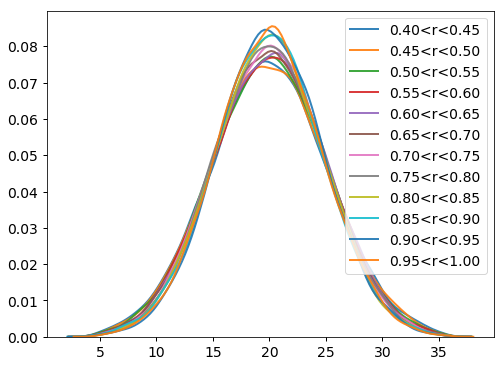

In [293]:
bins = np.linspace(0.4, 1, 13)
r_rbin, z_rbin, z_bins = profile_binning(x, y, bins)

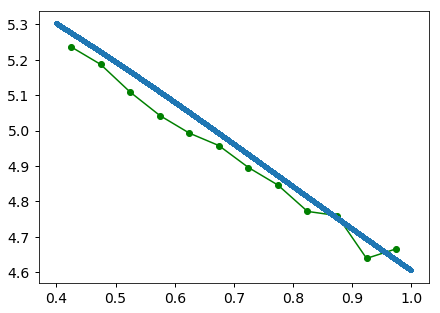

In [294]:
sigma_bins = np.array([np.std(z_bins[i]['pm']) for i in range(len(z_bins))])
plt.plot(r_rbin, sigma_bins, "g-o")
plt.plot(x, sig, '.')

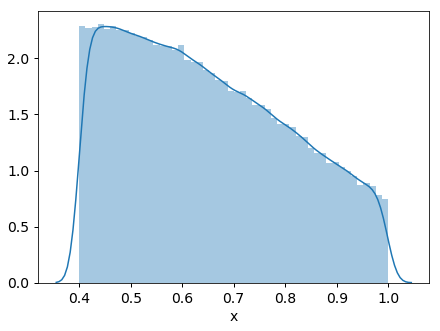

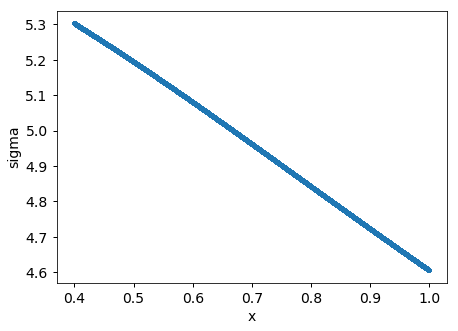

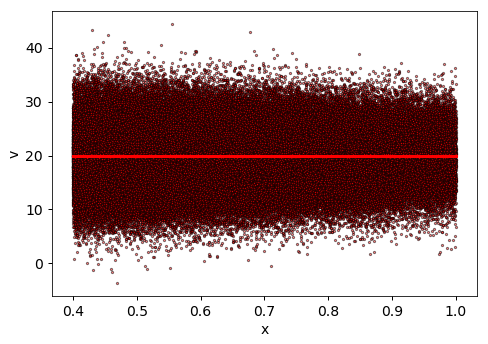

In [292]:
M_gc = 1e6
r_scale = 24
beta = 0.002
y_mean = 20

x = stats.truncnorm(loc=0.4, scale=0.4, a=0, b=1.5).rvs(200000)
sig = np.sqrt(sigmar_2(x, M_gc, r_scale, beta)).to_value(u.km/u.s)
X = x[:, np.newaxis]
y = y_mean + rng.normal(0, sig, X.shape[0])

import seaborn as sns
sns.distplot(x)
plt.xlabel("x")
plt.show()

plt.plot(x, sig, '.')
plt.xlabel("x")
plt.ylabel("sigma")

plt.figure(figsize=(7,5))
X_ = np.linspace(x.min(), x.max(), 100)
plt.scatter(X[:, 0], y, c='r', s=5, edgecolors=(0, 0, 0), alpha=0.5)
plt.plot(X_, y_mean*np.ones_like(X_), 'r', lw=3)
plt.xlabel("x")
plt.ylabel("v")
plt.tight_layout()

In [295]:
def prior(u):
    v = u.copy()
    v[0] = u[0] * 0.4 + 0.8 # M_GC
    v[1] = u[1] * 4 + 22  # r_scale
    v[2] = u[2] * 3 - 5   # log beta
    v[3] = u[3] * 4 + 18  # y_mean
    return v

def loglike(v):
    M_gc, r_scale, logbeta, y_mean = v
    M_gc = M_gc * 1e6
    beta = 10**logbeta
    
    ypred = y_mean
    sigma2 = sigmar_2(x, M_gc, r_scale, beta).to_value((u.km/u.s)**2)
    
    residsq = (ypred - y)**2 / sigma2
    loglike = -0.5 * np.sum(residsq + np.log(2 * np.pi * sigma2))

    if not np.isfinite(loglike):
        loglike = -1e100

    return loglike

In [296]:
nlive_init=100
nlive_batch=25
maxbatch=2
pfrac=0.8

dlogz = 1e-3 * (nlive_init - 1) + 0.01

def get_params_fit(results, return_sample=False):
    samples = results.samples                                 # samples
    weights = np.exp(results.logwt - results.logz[-1])        # normalized weights 
    pmean, pcov = dyfunc.mean_and_cov(samples, weights)       # weighted mean and covariance
    samples_eq = dyfunc.resample_equal(samples, weights)      # resample weighted samples
    pmed = np.median(samples_eq,axis=0)
    
    if return_sample:
        return pmed, pmean, pcov, samples_eq
    else:
        return pmed, pmean, pcov

In [297]:
start = time.time()
pdsampler = dynesty.DynamicNestedSampler(loglike, prior, 4)
pdsampler.run_nested(nlive_init=nlive_init, 
                     nlive_batch=nlive_batch, 
                     maxbatch=maxbatch, 
                     dlogz_init=dlogz, 
                     wt_kwargs={'pfrac': pfrac})
end = time.time()
print("Total Time Elapsed : %.1fs"%(end-start))

iter: 1519 | batch: 2 | bound: 26 | nc: 1 | ncall: 6987 | eff(%): 21.740 | loglstar: -606823.765 < -606820.031 < -606821.045 | logz: -606830.437 +/-  0.420 | stop:  4.876                            

Total Time Elapsed : 572.5s


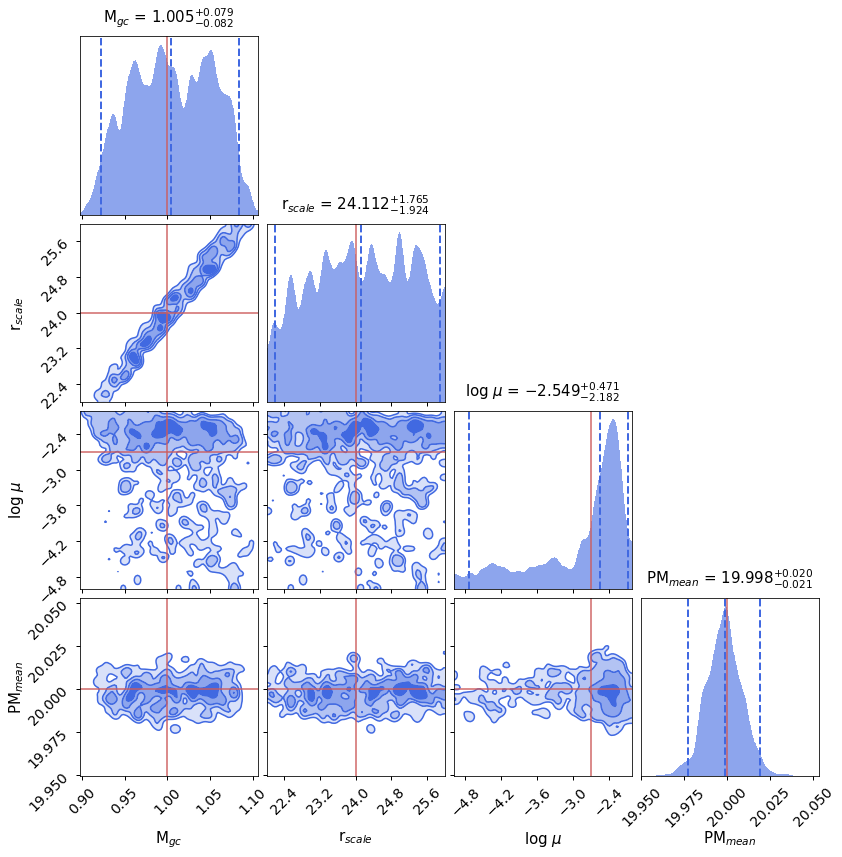

In [299]:
fig, ax = plt.subplots(4,4,figsize=(12,12))
dyplot.cornerplot(pdsampler.results, truths=[M_gc/1e6, r_scale, np.log10(beta), y_mean], labels=[r'M$_{gc}$', 'r$_{scale}$', 'log $\mu$', 'PM$_{mean}$'], 
                  color="royalblue", truth_color="indianred",
                  title_kwargs={'fontsize':15, 'y': 1.04}, title_fmt='.3f',
                  label_kwargs={'fontsize':15}, show_titles=True, fig=(fig,ax))
# plt.savefig("Tuc47_Model_dynesty.png", png=100)
plt.show()


In [223]:
drct = r"../data/"
gc_name = "NGC_104_47Tuc"

GC = GlobularCluster.from_directory(gc_name, drct)
GC.df.to_pandas().describe()

,x,y,pmx,pmy,pmx_e,pmy_e,pm_corr,g_mag,bp_rp,filter,memberprob,r,pm
count,90493.000000,90493.000000,90493.000000,90493.000000,90493.000000,90493.000000,90493.000000,90493.000000,72818.000000,90493.000000,90493.000000,90493.000000,90493.000000
mean,0.000156,-0.001003,5.069834,-2.391010,0.748230,0.620638,-0.075671,18.663277,0.902223,0.186291,0.172318,0.155831,5.962009
std,0.120260,0.120338,2.228220,1.715258,0.696715,0.602957,0.200438,1.435548,0.197522,0.389343,0.374415,0.068273,1.944638
min,-0.304802,-0.304871,-18.609150,-18.942380,0.023578,0.020528,-0.951285,10.600150,-1.243570,0.000000,0.000000,0.001046,0.014232
25%,-0.086928,-0.088950,4.563601,-2.982478,0.282561,0.232241,-0.184336,17.860400,0.791438,0.000000,0.000000,0.102253,5.270765
50%,-0.000863,-0.000408,5.225497,-2.455140,0.526232,0.425090,-0.070902,18.809510,0.873425,0.000000,0.000000,0.147533,5.875586
75%,0.087354,0.086612,5.831917,-1.870965,0.970185,0.772030,0.027872,19.691000,0.998234,0.000000,0.000000,0.206166,6.498322
max,0.304218,0.304813,19.767390,19.388680,5.227345,5.189505,0.982183,20.999230,4.339368,1.000000,0.998725,0.304992,19.986477


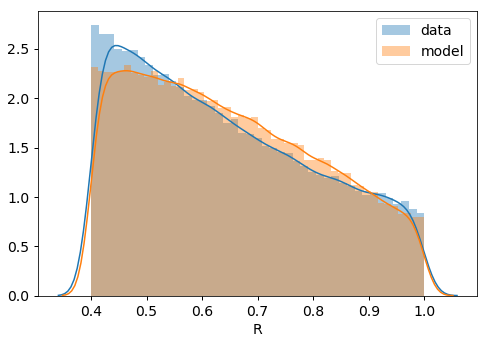

In [283]:
sns.distplot(GC.r[GC.r>0.4], label="data")
plt.xlabel("R")
sns.distplot(x, label="model")
plt.legend()
plt.tight_layout()
# plt.savefig("Tuc47_Model_r.png", png=50)


In [263]:
(GC.pm * dist / u.rad).to(u.km/u.s)

<Quantity [133.40510615, 128.05810865, 120.27376191, ..., 120.99106365,
           128.57998959, 104.54562291] km / s>

In [270]:
np.std((GC.pm[abs(GC.r-0.6)<0.1] * dist / u.rad).to(u.km/u.s))

<Quantity 37.49059248 km / s>

In [344]:
cond = (GC.df['memberprob']>0.5)
a = GC.df['pmx'][cond]
np.std(((a-a.mean())*dist/u.rad).to(u.km/u.s))

<Quantity 10.25372166 km / s>

In [345]:
b = GC.df['pmy'][cond]
np.std(((b-b.mean())*dist/u.rad).to(u.km/u.s))

<Quantity 9.29596096 km / s>

In [346]:
np.std((np.hypot((a-a.mean()),b-b.mean())*dist/u.rad).to(u.km/u.s))

<Quantity 7.57489039 km / s>

/home/qliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.


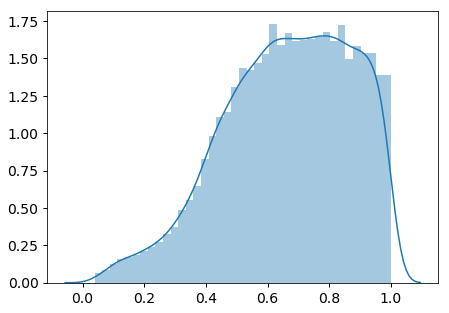

In [347]:
sns.distplot(GC.r[[cond]])

Text(0, 0.5, 'PM')

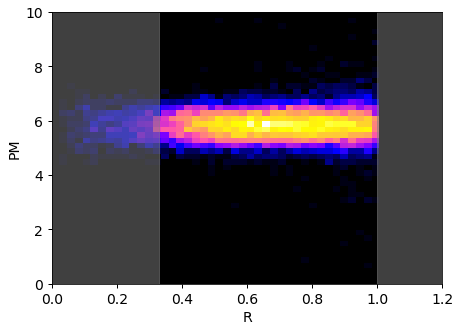

In [348]:
H, xb, yb, _ = plt.hist2d(GC.r[cond], GC.pm[cond], bins=50, range=[[0,1.2],[0,10]], norm=AsinhNorm(), cmap="gnuplot2")

plt.axvspan(0, 0.33, 0, color="gray", alpha=0.5)
plt.axvspan(1, 1.2, 0, color="gray", alpha=0.5)
plt.xlabel("R") # normalized
plt.ylabel("PM")